In [2]:
from gensim.models import Word2Vec
import gensim.downloader as api
from nltk.corpus import CategorizedPlaintextCorpusReader
import pandas as pd
import numpy as np
from util import corpus_to_df
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from scipy.sparse import hstack


from keras.models import Sequential
from keras import layers

import time
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
import gensim

from gensim.models.doc2vec import TaggedDocument
import re
from util import read_corpus
from util import split_data

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 42

Using TensorFlow backend.
/Users/septem/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/septem/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/septem/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/septem/anaconda3/lib/python3.6/site-packages/t

In [3]:
corpus_en_cleaned, corpus_nl_cleaned, corpus_cleaned = read_corpus('/Users/septem/Downloads/companies_cleaned/')

In [4]:
df = corpus_to_df(corpus_cleaned)

In [6]:
df_en = corpus_to_df(corpus_cleaned,lang='en')

In [24]:
model = Word2Vec([corpus_en_cleaned.words(id) for id in corpus_en_cleaned.fileids()],
                 size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

In [12]:
# print(api.load('glove-wiki-gigaword-100', return_path=True))

/Users/septem/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz


In [201]:
model.most_similar('innov')

[('innovation', 0.823898434638977),
 ('develop', 0.78158038854599),
 ('creativ', 0.7659180164337158),
 ('tomorrow', 0.7540677189826965),
 ('innovations', 0.7514084577560425),
 ('solutions', 0.7481990456581116),
 ('centric', 0.7413930892944336),
 ('pioneer', 0.7408238649368286),
 ('forefront', 0.7349944710731506),
 ('transform', 0.7328420877456665)]

In [27]:
model.get_vector('innov')

array([-0.6923239 ,  0.09054793,  0.70645565,  2.1132605 ,  2.5056994 ,
        2.8179712 ,  0.30747154, -1.0248929 ,  0.4417699 ,  0.16380109,
        1.5619235 ,  2.2814832 , -2.069246  , -1.9675705 , -6.80373   ,
        0.48478338,  0.13308588, -1.5050983 ,  2.0396683 , -0.24057171,
        1.0387337 , -0.37793085,  1.0940773 ,  1.1091944 ,  0.65006703,
        3.218774  ,  3.0125523 , -2.2331395 , -1.6542906 ,  0.3736558 ,
       -3.8481858 , -0.61232626], dtype=float32)

In [197]:
model.most_similar(positive=['sale','innov'])

[('today', 0.715315580368042),
 ('market', 0.6962562203407288),
 ('product', 0.6818262338638306),
 ('oem', 0.6814472079277039),
 ('sales', 0.674994707107544),
 ('flexibl', 0.6695233583450317),
 ('centrica', 0.6604280471801758),
 ('solutions', 0.651424765586853),
 ('custom', 0.6478621959686279),
 ('competit', 0.6276135444641113)]

In [30]:
model.most_similar(positive=['sale'],negative=['innov'])

[('cisg', 0.6819796562194824),
 ('representative', 0.6522023677825928),
 ('liais', 0.6447930335998535),
 ('credit', 0.6350514888763428),
 ('rep', 0.6234813928604126),
 ('enquiry', 0.6127030849456787),
 ('psh', 0.6110679507255554),
 ('extras', 0.6028674840927124),
 ('loan', 0.5703408718109131),
 ('dulimex', 0.5598212480545044)]

In [32]:
model.vocab['innov'].count

6004

In [33]:
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)[:1000]

print(words[::100])

[',', 'learn', 'effect', 'video', 'amsterdam', 'real', 'medic', 'heavi', 'competit', 'organis']


In [34]:
# for each word, compute it's vector with model
word_vectors = []

for i in words:
    word_vectors.append(model.get_vector(i))

In [38]:
word_vectors = np.array(word_vectors)

In [40]:
pca = PCA(n_components=2, random_state=42)
scaler = StandardScaler()
word_vectors_pca = pca.fit_transform(word_vectors)
word_vectors_pca = scaler.fit_transform(word_vectors_pca)

In [41]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [42]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1003', ...)

In [44]:
# map word vectors onto 2d plane with TSNE. hint: use verbose=100 to see what it's doing.
# normalize them as just lke with pca
word_tsne = X_embedded = TSNE(n_components=2).fit_transform(word_vectors)
word_tsne = scaler.fit_transform(word_tsne)

In [45]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

Figure(id='1110', ...)

In [7]:
tfidf = TfidfVectorizer()
tf_bi = CountVectorizer(min_df=5)

In [ ]:
tfidf

In [57]:
tf_bi_mat = tf_bi.fit_transform([corpus_en_cleaned.raw(id) for id in corpus_en_cleaned.fileids()])

In [8]:
tfidf_mat = tfidf.fit_transform([corpus_cleaned.raw(id) for id in corpus_cleaned.fileids()])

In [55]:
def document_vector(dictionary):
    for id in corpus_en_cleaned.fileids():
        [word for word in corpus_en_cleaned.word(id) if word in dictionary]

28476

In [63]:
tf_bi_pca = PCA(n_components=2).fit_transform(tf_bi_mat.toarray())

In [ ]:
tf_idf_pca = PCA(n_components=2).fit_transform(tfidf_mat.toarray())

In [71]:
def draw_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [80]:
pcaPCA(n_components=4)

((900, 97769), (900, 4))

(<Figure size 576x576 with 1 Axes>,
 [Text(-0.0202041,-0.0253856,'0'), Text(-0.0215226,-0.0280636,'1')])

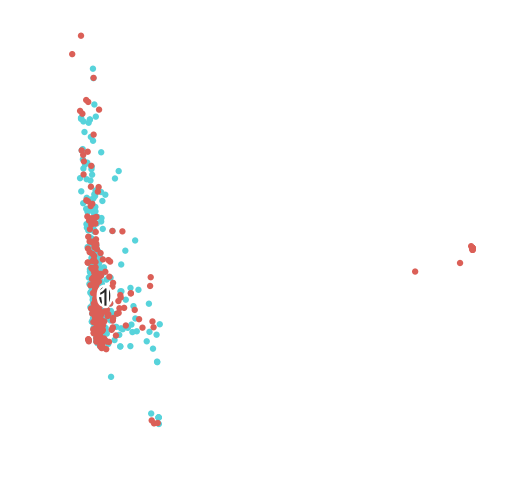

In [82]:
draw_scatter(tf_idf_pca, df_en['innov_'])

(<Figure size 576x576 with 1 Axes>,
 [Text(-60.9734,21.9023,'0'), Text(-42.7264,19.3909,'1')])

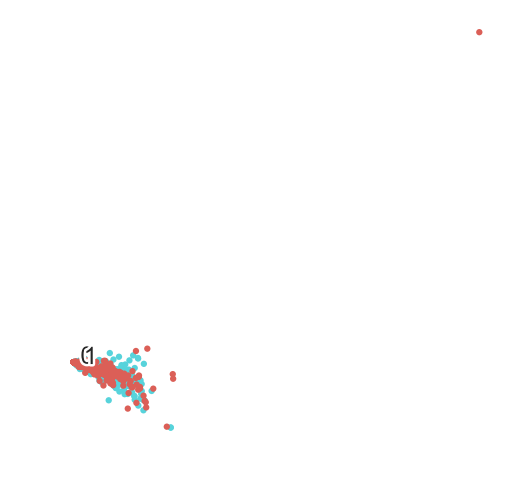

In [83]:
draw_scatter(tf_bi_pca, df_en['innov_'])

In [84]:
tsne_mat = TSNE(random_state=42).fit_transform(tfidf_mat)

(<Figure size 576x576 with 1 Axes>,
 [Text(0.320939,-2.41855,'0'), Text(0.959032,1.08174,'1')])

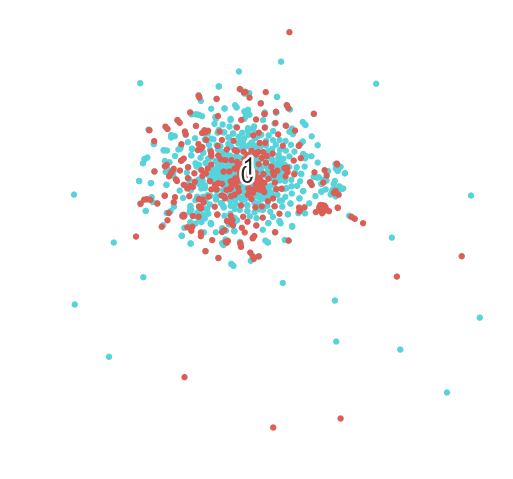

In [85]:
draw_scatter(tsne_mat, df_en['innov_'])

In [87]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [89]:
df_en

,id,lang,innov,innov_
0,en/innov/10000232.txt,en,innov,1
1,en/innov/10000364.txt,en,innov,1
2,en/innov/10010653.txt,en,innov,1
3,en/innov/10013385.txt,en,innov,1
4,en/innov/10025316.txt,en,innov,1
...,...,...,...,...
895,en/others/73077070.txt,en,others,0
896,en/others/73574864.txt,en,others,0
897,en/others/73893048.txt,en,others,0
898,en/others/74266195.txt,en,others,0


In [90]:
X_train, X_test, y_train, y_test = train_test_split([corpus_cleaned.raw(id) for id in df_en['id']], df_en['innov'], random_state=42, test_size=0.1)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

# dbow

In [96]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 900/900 [00:00<00:00, 619847.88it/s]


In [97]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 900/900 [00:00<00:00, 1497965.71it/s]


CPU times: user 6min 5s, sys: 2.9 s, total: 6min 8s
Wall time: 2min 20s


In [98]:

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [99]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [104]:
logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
logreg.score(test_vectors_dbow, y_test)

0.5666666666666667

In [106]:
model_dbow.save('d2v_model_dbow.doc2vec')

# dm

In [107]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 900/900 [00:00<00:00, 365251.44it/s]


In [108]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 900/900 [00:00<00:00, 754823.76it/s]


CPU times: user 10min 25s, sys: 5.73 s, total: 10min 30s
Wall time: 3min 31s


In [109]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [110]:
logreg.fit(train_vectors_dm, y_train)

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [111]:
logreg.score(test_vectors_dm, y_test)

0.6333333333333333

In [112]:
model_dm.save('d2v_model_dm.doc2vec')

In [113]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [114]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [115]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test), 600, 'Test')

In [116]:
%%time
logreg = LogisticRegression()
logreg.fit(train_vecs_dbow_dm, y_train)

CPU times: user 259 ms, sys: 10.1 ms, total: 269 ms
Wall time: 168 ms


/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
logreg.score(test_vecs_dbow_dm, y_test)

0.5666666666666667

In [144]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
#use anova f score to select the feature
NGRAM_RANGE = (1, 1)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2
MAX_DOC_FREQ = 0.95
def vectorize(train_texts, train_labels, test_texts, use_selector=True, score_function = f_classif):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
        'max_df' : MAX_DOC_FREQ
    }

    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(tokenizer=None, **kwargs)
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_test = tfidf_vectorizer.transform(test_texts)

    # Select best k features, with feature importance measured by f_classif
    if use_selector:
        selector = SelectKBest(score_function, k=min(TOP_K, x_train.shape[1]))
        selector.fit(x_train, train_labels)
        x_train = selector.transform(x_train).astype('float32')
        x_test = selector.transform(x_test).astype('float32')
#         scores = pd.DataFrame(list(zip(vectorizer.get_feature_names(), selector.scores_, selector.pvalues_)), 
#                                        columns=['ftr', 'score', 'pval'])
    return x_train, x_test, tfidf_vectorizer, selector if use_selector else None
    

In [145]:
x_train_tfidf, x_test_tfidf, tfidf_vec, selector = vectorize([' '.join(d.words) for d in X_train], y_train, 
                                                             [' '.join(d.words) for d in X_test])

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1813: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [156]:
x_comb_train = hstack((x_train_tfidf, train_vectors_dm))

In [157]:
x_comb_test = hstack((x_test_tfidf, test_vectors_dm))

In [158]:
x_comb_train.shape, x_comb_test.shape

((810, 20300), (90, 20300))

In [185]:
def train(x_train,y_train,x_test,y_test):
#     lg = LogisticRegression(solver='liblinear', C=1, penalty='l2',max_iter=1000)
#     lg = LogisticRegression()
    lg = LogisticRegression(n_jobs=-1, max_iter= 100, C= 5)
    lg.fit(x_train, y_train)
    print(classification_report(y_test, lg.predict(x_test),target_names=['others','innov']))

In [186]:
print('tfidf')
train(x_train_tfidf, y_train, x_test_tfidf, y_test)
print('dbow')
train(train_vectors_dbow, y_train, test_vectors_dbow, y_test)
print('dm')
train(train_vectors_dm, y_train, test_vectors_dm, y_test)
print('dbow_dm')
train(train_vecs_dbow_dm, y_train, test_vecs_dbow_dm, y_test)
print('tfidf_dm')
train(x_comb_train, y_train, x_comb_test, y_test)
print('tfidf_dm')
x_tfidf_dbow_train = hstack((x_train_tfidf, train_vectors_dbow))
x_tfidf_dbow_test  = hstack((x_test_tfidf, test_vectors_dbow))
train(x_tfidf_dbow_train, y_train, x_tfidf_dbow_test, y_test)

tfidf
              precision    recall  f1-score   support

      others       0.75      0.93      0.83        67
       innov       0.29      0.09      0.13        23

    accuracy                           0.71        90
   macro avg       0.52      0.51      0.48        90
weighted avg       0.63      0.71      0.65        90

dbow
              precision    recall  f1-score   support

      others       0.78      0.60      0.68        67
       innov       0.31      0.52      0.39        23

    accuracy                           0.58        90
   macro avg       0.55      0.56      0.53        90
weighted avg       0.66      0.58      0.60        90

dm
              precision    recall  f1-score   support

      others       0.74      0.78      0.76        67
       innov       0.25      0.22      0.23        23

    accuracy                           0.63        90
   macro avg       0.50      0.50      0.50        90
weighted avg       0.62      0.63      0.62        90

dbow_

In [192]:
len(model.vocab.keys())

28476

In [ ]:
df_nl = corpus_to_df(corpus_cleaned, language= 'nl')
x_train_tfidf, x_test_tfidf, tfidf_vec, selector = vectorize([' '.join(d.words) for d in X_train], y_train, 
                                                             [' '.join(d.words) for d in X_test])

In [21]:
count_vec = CountVectorizer(max_df=0.8, min_df=4, binary=True)
tfidf = TfidfVectorizer(max_df = 0.75, min_df = 4)

In [22]:
text_train, text_test, y_train, y_test = split_data(corpus_cleaned)
x_train = tfidf.fit_transform(text_train)
x_test = tfidf.transform(text_test)

In [23]:
x_trainain.shape

(4337, 71430)

In [24]:
svd = TruncatedSVD(n_components=2000)
x_train = svd.fit_transform(x_train)
x_test = svd.transform(x_test)

In [25]:
x_train.shape

(4337, 2000)

In [26]:
model = Sequential()
model.add(layers.Dense(10, input_dim = x_train.shape[1], activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                20010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 20,021
Trainable params: 20,021
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(x_train, 
                    y_train,epochs=100, 
                    verbose=False, 
                    validation_data=(x_test, y_test), 
                    batch_size=10)

In [33]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9786
Testing Accuracy:  0.5975


In [34]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

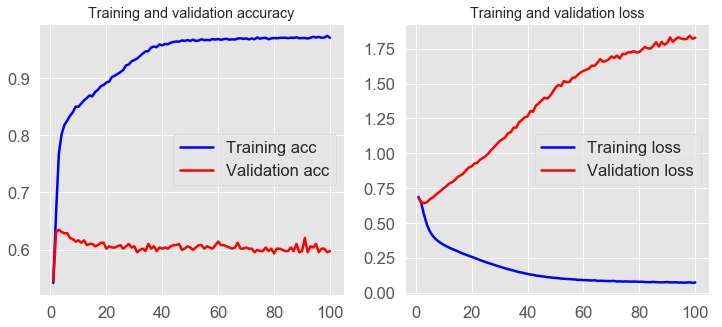

In [35]:
plot_history(history)

In [36]:
from keras.preprocessing.text import Tokenizer

In [61]:
corpus_en_raw, corpus_nl_raw, corpus_raw = read_corpus('/Users/septem/Downloads/companies2')
text_train, text_test, y_train, y_test = split_data(corpus_raw)

In [62]:
text_train = list(text_train)
text_test = list(text_test)

In [73]:
from keras.preprocessing.sequence import pad_sequences

In [74]:
maxlen = 100

In [83]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           25076400  
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 25,076,921
Trainable params: 25,076,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Seq

In [84]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

KeyboardInterrupt: 

In [86]:
model = Word2Vec([corpus_cleaned.words(id) for id in corpus_cleaned.fileids()],
                 size=100,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

In [89]:
model.most_similar('innovation', topn=30)

[('innov', 0.7122776508331299),
 ('entrepreneurship', 0.6833950281143188),
 ('strategic', 0.681466817855835),
 ('sustainability', 0.6539676189422607),
 ('scientific', 0.6463032364845276),
 ('forefront', 0.6410912275314331),
 ('advancement', 0.639877438545227),
 ('infosi', 0.6396197080612183),
 ('collabor', 0.6393698453903198),
 ('entrepreneuri', 0.6392096877098083),
 ('craftsmanship', 0.6317468285560608),
 ('transformation', 0.6289747357368469),
 ('centr', 0.6270175576210022),
 ('slotconferentie', 0.6256694793701172),
 ('empower', 0.6251667141914368),
 ('technological', 0.6244235634803772),
 ('foster', 0.6237552165985107),
 ('pioneer', 0.622428297996521),
 ('dedication', 0.6198509931564331),
 ('innovations', 0.6198229193687439),
 ('excellence', 0.6197081804275513),
 ('digitization', 0.6188362240791321),
 ('collaboration', 0.617637574672699),
 ('groundbreak', 0.6169220805168152),
 ('ongo', 0.615318775177002),
 ('creativity', 0.6150135397911072),
 ('daring', 0.6131162047386169),
 ('innov

In [90]:
len(model.wv.vocab)

/Users/septem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


110166

In [92]:
with open('website.word2vec', 'wb') as f:
    model.save_word2vec_format(f)

In [94]:
embedding = model.get_keras_embedding(train_embeddings=False)

In [97]:
embedding.get_config()

{'name': 'embedding_4',
 'trainable': False,
 'batch_input_shape': (None, None),
 'dtype': 'float32',
 'input_dim': 110166,
 'output_dim': 100,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': None}

In [98]:
from keras.layers import GRU,LSTM,Embedding, Dense

In [101]:
tokenizer = Tokenizer()

In [103]:
tokenizer.fit_on_texts([corpus_cleaned.raw(id) for id in corpus_cleaned.fileids()])

In [104]:
sequences = tokenizer.texts_to_sequences([corpus_cleaned.raw(id) for id in corpus_cleaned.fileids()])

In [105]:
len(tokenizer.word_index)

418597

In [106]:
word_lengths = [len(corpus_cleaned.words(id)) for id in corpus_cleaned.fileids()]

(array([2215.,  562.,  385.,  357.,  268.,  284.,  285.,  329.,   88.,
          26.]),
 array([1.20000e+01, 1.62530e+03, 3.23860e+03, 4.85190e+03, 6.46520e+03,
        8.07850e+03, 9.69180e+03, 1.13051e+04, 1.29184e+04, 1.45317e+04,
        1.61450e+04]),
 <a list of 10 Patch objects>)

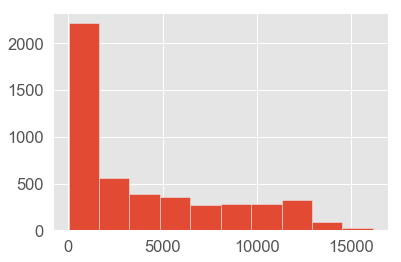

In [114]:
plt.hist(sorted(word_lengths)[:-20],bins=10)

In [115]:
x_pad = pad_sequences(sequences, maxlen = 10000)

In [116]:
x_pad.shape

(4819, 10000)

In [117]:
num_of_words = len(tokenizer.word_index)+1

In [118]:
num_of_words

418598

In [119]:
embedding_matrix = np.zeros((num_of_words, 100))

In [128]:
's' in model.wv.vocab

/Users/septem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


True

In [129]:
for word, i in tokenizer.word_index.items():
    if i > num_of_words:
        continue
    if word in model.wv.vocab:
        embedding_vector = model.wv.get_vector(word)
        embedding_matrix[i] = embedding_vector

/Users/septem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/Users/septem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [130]:
from keras.initializers import Constant

In [133]:
model.wv
nn = Sequential()
embedding_layer = Embedding(num_of_words, 100, 
                            embeddings_initializer= Constant(embedding_matrix),
                            input_length= 10000,trainable=False
                           )
nn.add(embedding_layer)
nn.add(GRU(units=32,dropout=0.2,recurrent_dropout=0.2))
nn.add(Dense(1,activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer = 'adam',metrics = ['accuracy'])
nn.summary()

/Users/septem/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10000, 100)        41859800  
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 41,872,601
Trainable params: 12,801
Non-trainable params: 41,859,800
_________________________________________________________________


In [136]:
x_train_pad,x_test_pad, y_train,y_test = train_test_split(
    x_pad,
    df['innov_'], 
    stratify = df['innov_'],
    test_size=0.1)

In [137]:
x_train_pad.shape, x_test_pad.shape

((4337, 10000), (482, 10000))

In [140]:
nn.fit(x_train_pad, y_train, batch_size=128,epochs=25, validation_data=(x_test_pad, y_test), verbose=2)

Train on 4337 samples, validate on 482 samples
Epoch 1/25
 - 1773s - loss: 0.7064 - acc: 0.5363 - val_loss: 0.7049 - val_acc: 0.5415
Epoch 2/25
 - 2005s - loss: 0.6922 - acc: 0.5555 - val_loss: 0.7005 - val_acc: 0.5519
Epoch 3/25
 - 1146s - loss: 0.6796 - acc: 0.5757 - val_loss: 0.6960 - val_acc: 0.5726
Epoch 4/25
 - 861s - loss: 0.6651 - acc: 0.5970 - val_loss: 0.6927 - val_acc: 0.5934
Epoch 5/25
 - 868s - loss: 0.6648 - acc: 0.5933 - val_loss: 0.6929 - val_acc: 0.5954
Epoch 6/25
 - 865s - loss: 0.6598 - acc: 0.5995 - val_loss: 0.6905 - val_acc: 0.5851
Epoch 7/25
 - 838s - loss: 0.6531 - acc: 0.6156 - val_loss: 0.6949 - val_acc: 0.5830
Epoch 8/25
 - 764s - loss: 0.6473 - acc: 0.6226 - val_loss: 0.6945 - val_acc: 0.5954
Epoch 9/25
 - 817s - loss: 0.6456 - acc: 0.6221 - val_loss: 0.6954 - val_acc: 0.5892
Epoch 10/25
 - 769s - loss: 0.6367 - acc: 0.6341 - val_loss: 0.6988 - val_acc: 0.5809
Epoch 11/25
 - 909s - loss: 0.6362 - acc: 0.6412 - val_loss: 0.7006 - val_acc: 0.5892
Epoch 12/25
 

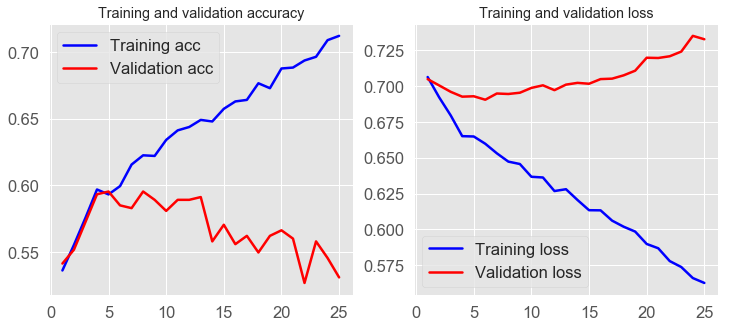

In [141]:
plot_history(nn.history)